<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/Contrastive_Loss_Tests_on_Experiments_1_(S1_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation
---

In [1]:
# !pip install captum
# !pip install umap-learn
# !pip install datashader
# !pip install bokeh
# !pip install holoviews
!pip install tensorboardX
!pip install optuna
!pip install captum
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install imbalanced-learn


In [2]:
!pip install torchvision

---
VAE Experiment 1 **[]** 6/12
---

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd
import numpy as np
import os

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

import torchvision
from torchvision import datasets

#based on sensor data can you determine the stimulus that is currently in use?
import optuna
from optuna.pruners import ThresholdPruner
from optuna.pruners import PatientPruner
from optuna.pruners import MedianPruner
from optuna import TrialPruned

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [4]:
import pandas as pd
import numpy as np

# Load the DataFrame from the CSV file
df = pd.read_csv("Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/ALL_E1_A1_1_10.csv")

# Drops all 0 labels (no label)
indices_to_drop = df[df["stimulus"] == 0].index
df.drop(indices_to_drop, inplace=True)

# Identify the indices of data points corresponding to stimulus 10
stimulus_10_indices = df[df["stimulus"] == 10].index

# Number of data points to remove from stimulus 10
points_to_remove = 10000

# Randomly select 10,000 indices from stimulus 10
indices_to_remove = np.random.choice(stimulus_10_indices, points_to_remove, replace=False)

# Remove the selected indices from the DataFrame
df.drop(indices_to_remove, inplace=True)

#Removes number of features from data
# df.drop('Cyber Glove (angles of the joints) Sensor 1', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 2', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 3', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 4', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 5', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 6', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 7', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 8', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 9', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 10', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 11', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 12', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 13', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 14', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 15', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 16', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 17', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 18', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 19', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 20', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 21', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 22', inplace=True, axis=1)

In [5]:
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
0,1,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
1,1,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
2,1,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
3,1,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
4,1,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


In [6]:
X = df.drop('stimulus', axis=1)
#y = df['stimulus']
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()

(880259, 41) <class 'pandas.core.frame.DataFrame'> (880259, 1) <class 'pandas.core.frame.DataFrame'>



In [7]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
0,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
1,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
2,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
3,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
4,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


---
Visualization number of labels

stimulus
10          77712
6           74184
5           74096
7           73998
8           73849
11          73798
12          73538
4           72792
3           72056
9           71624
1           71483
2           71129
dtype: int64

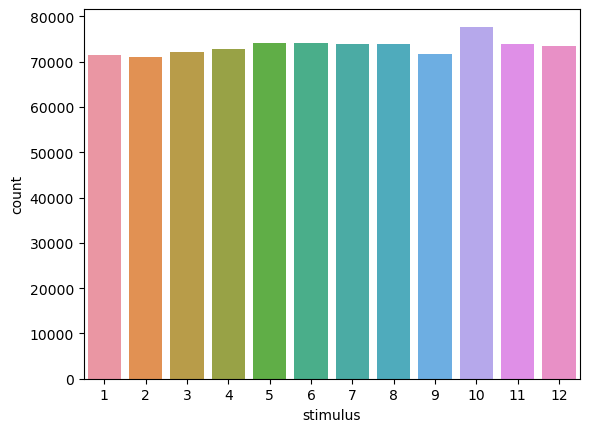

In [8]:
sns.countplot(x = 'stimulus', data=df)
y.value_counts()

---
Fixing Data Imbalance via Undersampling

In [9]:
print(y.value_counts())
print(len(X.value_counts()))

stimulus
10          77712
6           74184
5           74096
7           73998
8           73849
11          73798
12          73538
4           72792
3           72056
9           71624
1           71483
2           71129
dtype: int64
880259


In [10]:
print(y)

        stimulus
0              1
1              1
2              1
3              1
4              1
...          ...
890254        12
890255        12
890256        12
890257        12
890258        12

[880259 rows x 1 columns]


---
Visualization of Data Distributions

In [11]:
# #distribution of first 19 features


# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(40, 40))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 20:
#     break
# plt.tight_layout()

---
Defining Hyperparmaeters

In [12]:
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

#Hyperparameters
emg_channels = 16
imu_channels = 3

latent_dim = 2
input_dim= len(X.columns)

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
output_dim = len(X.columns)
num_classes = 12
num_layers = round(num_classes/2)
tempature = 1

num_epochs= 10
batch_size= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0


alpha = 2        # Reconstruction Loss
beta = 2         # Kl Divergence Loss
gamma = 3        # Classifcation Loss
delta = 5        # Contrastive Loss
epsilon = 3      # Triplet Loss

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train Test Split

In [13]:
print(X.shape, type(X), y.shape, type(y))
print()

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

(880259, 41) <class 'pandas.core.frame.DataFrame'> (880259, 1) <class 'pandas.core.frame.DataFrame'>

X_train size: 528155 | X_val size: 176052 | X_test size: 176052
y_train size: 528155 | y_val size: 176052 | y_test size: 176052

Training Feature Split: (528155, 41) | Training Labels (528155, 1)
Validation Feature Split: (176052, 41) | Validation Labels (176052, 1)
Testing Feature Split: (176052, 41) | Testing Labels (176052, 1)



In [14]:
# from sklearn.ensemble import GradientBoostingRegressor
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,8))
# plt.xlabel('Feature Number', fontsize=13)
# plt.ylabel('Percentage (%)', fontsize=13)
# plt.title('Feature Importance', fontsize=15)

# gb = GradientBoostingRegressor(n_estimators=100)
# gb.fit(X_train, y_train.values.ravel())  # Convert y_train to a 1D array using .values.ravel()

# plt.bar(range(X_train.shape[1]), (gb.feature_importances_) * 100)

# # Update the x-tick positions with desired values
# custom_xticks = [1, 2, 3, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
# plt.xticks(range(X_train.shape[1]), custom_xticks)

# plt.show()
# plt.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Feature_Importance_S1-10.svg')
# plt.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Feature_Importance_S1-10.png')


---
Scaling/Normalizing Data

In [15]:
#Normalization Data

#No Normalization
# X_train_Normalized = X_train
# X_val_Normalized = X_val
# X_test_Normalized = X_test
#----------------------------------------------------------------------------------------------------------
# Minmax without preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train)
# X_val_Normalized = Minmax.transform(X_val)
# X_test_Normalized = Minmax.transform(X_test)
#----------------------------------------------------------------------------------------------------------
# Minmax with preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train_preprocessed)
# X_val_Normalized = Minmax.transform(X_val_preprocessed)
# X_test_Normalized = Minmax.transform(X_test_preprocessed)

#----------------------------------------------------------------------------------------------------------
# # Standardization without preprocessing
Standardized = preprocessing.StandardScaler()
X_train_Normalized= Standardized.fit_transform(X_train)
X_val_Normalized = Standardized.transform(X_val)
X_test_Normalized = Standardized.transform(X_test)

# Standardization with preprocessing
# Standardized = preprocessing.StandardScaler()
# X_train_Normalized= Standardized.fit_transform(X_train_preprocessed)
# X_val_Normalized = Standardized.transform(X_val_preprocessed)
# X_test_Normalized = Standardized.transform(X_test_preprocessed)
#----------------------------------------------------------------------------------------------------------

# Convert to numpy then to torch
X_train = torch.from_numpy(X_train_Normalized).float()
y_train = torch.from_numpy(y_train.values.ravel()).long()  # Extract the NumPy array using .values.ravel()

X_val = torch.from_numpy(X_val_Normalized).float()
y_val = torch.from_numpy(y_val.values.ravel()).long()

X_test = torch.from_numpy(X_test_Normalized).float()
y_test = torch.from_numpy(y_test.values.ravel()).long()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , {y_train.shape}")
print(f"Validation: {X_val.shape} , {y_val.shape}")
print(f"Testing: {X_test.shape} , {y_test.shape}")

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([528155, 41]) , torch.Size([528155])
Validation: torch.Size([176052, 41]) , torch.Size([176052])
Testing: torch.Size([176052, 41]) , torch.Size([176052])


---
Defining Dataloaders


In [16]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [17]:
training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

def get_data_loader(optuna_batch_size):
  train_loader = DataLoader(training, batch_size=optuna_batch_size, shuffle=True)
  val_loader = DataLoader(validating, batch_size=optuna_batch_size, shuffle=False)
  test_loader = DataLoader(testing, batch_size=optuna_batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

---
Defining VAE Model, Loss and Optmizers

In [18]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.ReLU(),
        nn.Linear(num_layers, 13),
        nn.Softmax(dim=1)
    )

  def encode(self, x):
    z = self.encoder(x)
    z1 = self.mu(z)
    z2 = self.logvar(z)
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)
    classified = classified / tempature

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")

  print(f"Logvar: {logvar.shape}")

  print(f"Latent Space Z: {z_reparmeterized.shape}")

  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 13])


In [19]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z_reparmeterized, labels):
        # Compute the pairwise euclidean distances between the examples in the latent space
        distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
        # Create a mask for the positive pairs (i.e. examples with the same label)
        positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Create a mask for the negative pairs (i.e. examples with different labels)
        negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Set the distances for the positive pairs to a large value
        distances.masked_fill_(positive_mask, 1e7)

        # Compute the contrastive loss for both positive and negative pairs
        #positive_loss = torch.sum(torch.min(distances, dim=1)[0]* positive_mask.float())
        negative_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * negative_mask.float())
        positive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * positive_mask.float())

        # Combine the positive and negative losses
        contrastive_loss =  negative_loss + positive_loss

        return contrastive_loss

---
HyperParameter Optimization
---



In [20]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim,hidden_dim_2, latent_dim):
    super(VAE,self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.Tanh(),
        nn.Linear(num_layers, 12),
        nn.Softmax(dim=1)
    )

  def encode(self, x):
    z = self.encoder(x)
    z1 = self.mu(z)
    z2 = self.logvar(z)
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim,hidden_dim_2, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")

  print(f"Logvar: {logvar.shape}")

  print(f"Latent Space Z: {z_reparmeterized.shape}")

  print(f"Classifier: {classified.shape}")

  print(f"Latent Space Z: {z_reparmeterized.shape}")

  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 12])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 12])


In [21]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z_reparmeterized, labels):
        # Compute the pairwise euclidean distances between the examples in the latent space
        distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
        # Create a mask for the positive pairs (i.e. examples with the same label)
        positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Create a mask for the negative pairs (i.e. examples with different labels)
        negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Set the distances for the positive pairs to a large value
        distances.masked_fill_(positive_mask, 1e7)

        # Compute the contrastive loss for both positive and negative pairs
        #positive_loss = torch.sum(torch.min(distances, dim=1)[0]* positive_mask.float())
        negative_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * negative_mask.float())
        positive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * positive_mask.float())

        # Combine the positive and negative losses
        contrastive_loss =  negative_loss + positive_loss

        return contrastive_loss

In [22]:
def train_VAE(trial, model, train_loader, val_loader, optimizer, epoch,alpha,beta,gamma, delta, contrastive_margin):
  train_losses=[]
  train_accuracy = []
  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  recon_loss_fn = nn.MSELoss(reduction="sum")
  classifier_loss_fn = nn.CrossEntropyLoss()
  contrastive_loss_fn = ContrastiveLoss(margin=contrastive_margin)

  train_running_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()

    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = recon_loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 12)
    labels = labels - 1
    classification_loss = classifier_loss_fn(classified, labels.flatten())


    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + (delta*contrastive_loss)

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = recon_loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 12)
      # Compute the classification
      Y= Y-1
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # print(epoch)
  # if epoch == num_epochs-1:
  #   print(model)
  trial.report(train_acc, epoch)
  if trial.should_prune():
      raise optuna.TrialPruned()

  return train_losses, val_losses, train_acc, val_acc




In [23]:
num_epochs = 20
hidden_dim_2 = 1
def objective(trial):
  params = {
          'optuna_batch_size' : trial.suggest_int('optuna_batch_size', 1e2, 1e4),
          'num_epochs' : num_epochs,
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
          "lr": trial.suggest_float('lr', 1e-4, 1e0),
          "hidden_dim": trial.suggest_int('hidden_dim', 1e1, 2e2),
          'alpha': trial.suggest_int('alpha', 1e0, 5e0),
          'beta': trial.suggest_int('beta', 1e0, 5e0),
          'gamma': trial.suggest_int('gamma', 1e0, 5e0),
          'delta': trial.suggest_int('delta', 1e0, 5e0),
          'contrastive_margin': trial.suggest_int('contrastive_margin', 1e0, 1e1)
  }

  train_loader, val_loader, test_loader = get_data_loader(params['optuna_batch_size'])
  model  = VAE(input_dim, params['hidden_dim'],params['hidden_dim']//2,latent_dim).to(device)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

  for epoch in range(params['num_epochs']):
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta, params['contrastive_margin'])
  return train_acc


In [24]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(
    sampler=sampler,
    pruner = PatientPruner(MedianPruner(), patience=1),
    direction='maximize')
study.optimize(func=objective, n_trials=200)

C:\Users\kcurr\AppData\Local\Temp\ipykernel_20392\2399313174.py:4: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = PatientPruner(MedianPruner(), patience=1),
[I 2023-07-06 09:06:40,863] A new study created in memory with name: no-name-f970250d-c4b4-4ecf-8a32-2c9fc51fb7f1


Epoch: 1 / 20 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 8.088 % ||| Val Loss: nan | Val acc: 8.155 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 20 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 8.089 % ||| Val Loss: nan | Val acc: 8.155 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 20 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 8.082 % ||| Val Loss: nan | Val acc: 8.155 %
------------------------------------------------------------------------------------------------------------

[W 2023-07-06 09:37:23,162] Trial 0 failed with parameters: {'optuna_batch_size': 2111, 'optimizer': 'Adam', 'lr': 0.5976075339251424, 'hidden_dim': 172, 'alpha': 5, 'beta': 4, 'gamma': 4, 'delta': 5, 'contrastive_margin': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\kcurr\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\kcurr\AppData\Local\Temp\ipykernel_20392\2845384582.py", line 22, in objective
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta, params['contrastive_margin'])
  File "C:\Users\kcurr\AppData\Local\Temp\ipykernel_20392\1344714958.py", line 29, in train_VAE
    contrastive_loss = contrastive_loss_fn(mu, labels)
  File "C:\Users\kcurr\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 1501, in _call_impl
    return forward_ca

KeyboardInterrupt: ignored

In [ ]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study,params=['lr'])

In [ ]:
optuna.visualization.plot_intermediate_values(study)

---
Training and Validation
---

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.Tanh(),
        nn.Linear(num_layers, 12),
        nn.Softmax(dim=1)
    )

  def encode(self, x):
    z = self.encoder(x)
    z1 = self.mu(z)
    z2 = self.logvar(z)
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")

  print(f"Logvar: {logvar.shape}")

  print(f"Latent Space Z: {z_reparmeterized.shape}")

  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([10000, 41])
Mu: torch.Size([10000, 2]) 
Logvar: torch.Size([10000, 2])
Latent Space Z: torch.Size([10000, 2])
Classifier: torch.Size([10000, 12])


In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z_reparmeterized, labels):
        # Compute the pairwise euclidean distances between the examples in the latent space
        distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
        # Create a mask for the positive pairs (i.e. examples with the same label)
        positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Create a mask for the negative pairs (i.e. examples with different labels)
        negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
        # Set the distances for the positive pairs to a large value
        distances.masked_fill_(positive_mask, 1e7)

        # Compute the contrastive loss for both positive and negative pairs
        #positive_loss = torch.sum(torch.min(distances, dim=1)[0]* positive_mask.float())
        negative_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * negative_mask.float())
        positive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances) * positive_mask.float())

        # Combine the positive and negative losses
        contrastive_loss =  negative_loss + positive_loss

        return contrastive_loss


In [ ]:
# Loss Functions
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()
contrastive_loss_fn = ContrastiveLoss(margin=2)

#############################################################################################################################################################################################################

#Hyperparameters
latent_dim = 2

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
num_classes = 12
num_layers = round(num_classes/2)

num_epochs= 50
lr= 0.006
batch_size= 200
hidden_dim= 20

alpha= 1
beta=  1
gamma= 1
delta= 1

# Best Accuracy: 94.58%
# optuna_batch_size= 367
# optimizer= Adam
# lr= 0.008033274147278979
# hidden_dim= 915
# alpha= 7
# beta= 7
# gamma= 10
# delta= 5
# contrastive_margin= 2

train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

# #Model and Optmimizer
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=41, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
  )
  (mu): Linear(in_features=10, out_features=2, bias=True)
  (logvar): Linear(in_features=10, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=41, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=12, bias=True)
    (

---
Train and Validation loop

In [ ]:
target_accuracy = 0.0
restart = True
while restart:

  train_losses=[]
  train_accuracy = []

  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  train_acces = []
  val_acces = []

  dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())

  for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0


    z_list, means, logvars , labels_list = list(), list(), list(), list()

    for i, data in enumerate(train_loader):
      inputs, labels = data
      # print(f"Input shape: {inputs.shape}")
      #print(f"Labels shape: {labels.shape}")
      optimizer.zero_grad()

      x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

      # Compute the reconstruction loss and KL divergence loss #################################################

      reconstruction_loss = loss_fn(x_reconstructed, inputs)
      kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Compute the contrastive loss #############################################################################
      contrastive_loss = contrastive_loss_fn(mu, labels)

      # Compute the classificaiton loss #########################################################################
      classified = classified.view(-1, 12)
      labels = labels - 1
      #print(f"Labels shape: {labels.shape}")
      classification_loss = classifier_loss_fn(classified, labels.flatten())

      #print(classified.shape)

      loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + delta*contrastive_loss #+ epsilon*triplet_loss

      accuracy = accuracy_score(labels, classified.argmax(dim=1))
      train_accuracy.append(accuracy)
      train_acc = sum(train_accuracy)/len(train_accuracy)
      accuracy_log.append(train_acc)

      loss.backward()
      optimizer.step()

      train_running_loss += loss.item()
      train_loss= train_running_loss/len(train_loader)

    # log for latent space visualziation (gif)...
      z_list.append(z_reparmeterized.detach())
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels_list.append(labels.detach())

    with torch.inference_mode():
      val_running_loss = 0
      val_running_acc = 0

      model.eval()
      # Iterate over the validation data
      for X, Y in val_loader:
        # Pass the data through the model and get the reconstructed data and the latent representation
        y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

        # Compute the reconstruction loss
        v_reconstruction_loss = loss_fn(y_pred, X)

        # Compute the KL divergence loss
        v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Compute the contrastive loss
        v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

        # Reshape the classified output to have the same shape as the labels
        v_classified = v_classified.view(-1, 12)
        # Compute the classification
        Y= Y-1
        v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

        # Compute the total loss
        vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
        val_running_loss += vloss.item()
        val_loss = val_running_loss/len(val_loader)

        v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
        val_accuracy.append(v_accuracy)
        val_acc = sum(val_accuracy)/len(val_accuracy)

    dic['latent_space'].append(torch.cat(z_list))
    dic['mu_list'].append(torch.cat(means))
    dic['logsig2_list'].append(torch.cat(logvars))
    dic['y'].append(torch.cat(labels_list))

    print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acces.append(train_acc)
    val_acces.append(val_acc)

    if epoch == num_epochs -1:
      if train_acc > target_accuracy:
        restart = False
        print("Training completed successfully!")
        break
      else:
        model  = VAE(input_dim, hidden_dim ,latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print("Restarting the training...")



Epoch: 1 / 50 | Reconst_loss: 4726.641 | Kldiv loss: 1576.731 | Classifcation loss: 2.408 | Constrast loss: 985.42 | Total loss: 10164.597 | Train acc: 19.375 % ||| Val Loss: 9176.640 | Val acc: 24.384 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 50 | Reconst_loss: 3535.422 | Kldiv loss: 1568.738 | Classifcation loss: 2.328 | Constrast loss: 1025.62 | Total loss: 9074.790 | Train acc: 22.397 % ||| Val Loss: 8971.291 | Val acc: 25.590 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 50 | Reconst_loss: 4567.570 | Kldiv loss: 1518.309 | Classifcation loss: 2.346 | Constrast loss: 947.28 | Total loss: 8937.722 | Train acc: 24.256 % ||| Val Loss: 8970.114 | Val acc: 26.584 %
-------------------------

In [ ]:
torch.save(model.state_dict(), f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/VAE_Model_S1-10_{train_acc*100:.1f}"+".pt") # Save

---
Model Evaluations

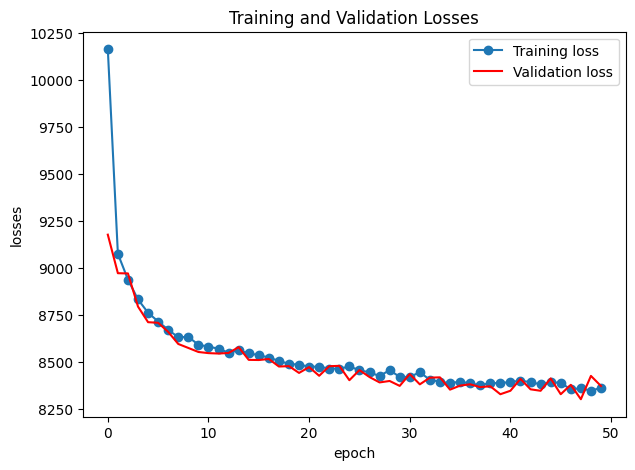

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

fig.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Training_and_Validation_Loss_S1-10.svg')
fig.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Training_and_Validation_Loss_S1-10.png')

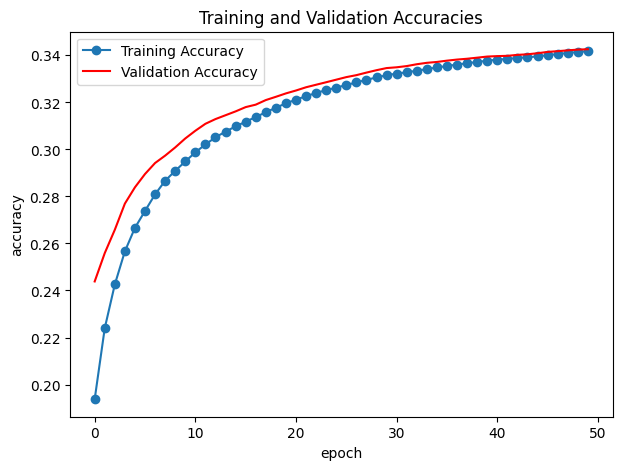

In [ ]:
fig = plt.figure(figsize=(7,5))
plt.plot(train_acces,'-o', label="Training Accuracy")
plt.plot(val_acces,'-r',  label="Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

fig.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Training_and_Validation_Accuracies_S1-10.svg')
fig.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Training_and_Validation_Accuracies_S1-10.png')

---
Latent Space Visualization

In [ ]:
print("Latent Space Visualization")
for i in range(num_epochs):
  fig = plt.figure(figsize=(12, 12))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()
  y_arr = y_arr + 1

  plt.scatter(z_arr[:, 0], z_arr[:, 1], c=y_arr, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('gist_rainbow', num_classes), vmin=1, vmax=12)
  cb = plt.colorbar(ticks=range(1, 13), values=range(1, 13))
  cb.ax.tick_params(labelsize=10)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.xlabel('z[0]', fontsize=10)
  plt.ylabel('z[1]', fontsize=10)
  plt.title(f'VAE train dataset with {input_dim} features| Acc: {train_acc*100:.1f}% | latent space Dim={latent_dim} | Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/VAEtrain_images{i:001}" + ".png")
  fig.savefig(f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/VAEtrain_svg{i:001}" + ".svg")

  print(f"Latent Space Image {i+1} stored.")
print()
print("Latent Space Gif being created...")
print()


Latent Space Visualization


C:\Users\kcurr\AppData\Local\Temp\ipykernel_22392\100244150.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(z_arr[:, 0], z_arr[:, 1], c=y_arr, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('gist_rainbow', num_classes), vmin=1, vmax=12)


Latent Space Image 1 stored.
Latent Space Image 2 stored.
Latent Space Image 3 stored.
Latent Space Image 4 stored.
Latent Space Image 5 stored.
Latent Space Image 6 stored.
Latent Space Image 7 stored.
Latent Space Image 8 stored.
Latent Space Image 9 stored.
Latent Space Image 10 stored.
Latent Space Image 11 stored.
Latent Space Image 12 stored.
Latent Space Image 13 stored.
Latent Space Image 14 stored.
Latent Space Image 15 stored.
Latent Space Image 16 stored.
Latent Space Image 17 stored.
Latent Space Image 18 stored.
Latent Space Image 19 stored.
Latent Space Image 20 stored.
Latent Space Image 21 stored.
Latent Space Image 22 stored.
Latent Space Image 23 stored.
Latent Space Image 24 stored.
Latent Space Image 25 stored.
Latent Space Image 26 stored.
Latent Space Image 27 stored.
Latent Space Image 28 stored.
Latent Space Image 29 stored.
Latent Space Image 30 stored.
Latent Space Image 31 stored.
Latent Space Image 32 stored.
Latent Space Image 33 stored.
Latent Space Image 

In [ ]:
import imageio
gif = []
for i in range(4):
  each_image = imageio.imread(f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave(f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Latent_Space_and_Number_Features_S1-10_{input_dim}_{train_acc*100:.1f}.gif",gif)
imageio.mimsave(f"Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Latent_Space_and_Number_Features_S1-10_{input_dim}_{train_acc*100:.1f}.gif",gif)

ModuleNotFoundError: ignored

              precision    recall  f1-score   support

           1       0.45      0.28      0.35     14416
           2       0.34      0.49      0.40     14035
           3       0.25      0.05      0.09     14315
           4       0.16      0.25      0.20     14557
           5       0.50      0.34      0.40     14761
           6       0.24      0.38      0.30     14814
           7       0.40      0.37      0.38     15016
           8       0.39      0.18      0.25     14680
           9       0.36      0.43      0.39     14377
          10       0.53      0.31      0.39     15486
          11       0.32      0.58      0.42     14814
          12       0.51      0.53      0.52     14781

    accuracy                           0.35    176052
   macro avg       0.37      0.35      0.34    176052
weighted avg       0.37      0.35      0.34    176052



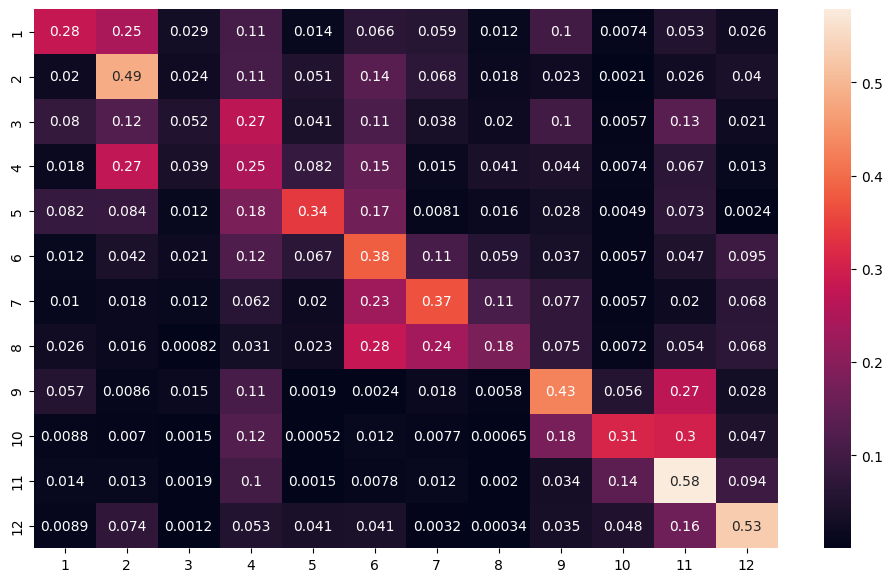

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
  x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)
  classified = (torch.max(torch.exp(classified), 1)[1]).data.cpu().numpy()
  y_pred.extend(classified) # Save Prediction

  labels = labels-1

  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12',)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Confusion_Matrix.png')
plt.savefig('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Confusion_Matrix.svg')

from sklearn import metrics
from sklearn.metrics import classification_report
label_names = ['1', '2', '3', '4','5','6','7','8','9','10','11','12']
print(classification_report(y_true, y_pred,target_names=label_names))

report = classification_report(y_true, y_pred,target_names=label_names,output_dict=True)

df_report = pd.DataFrame(report).T
df_report.head()

df_report.to_csv('Downloads/All_VAE_For_Subject_1/Subject_Experiment_1/Classification_Report.csv')